# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

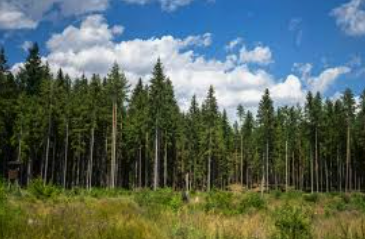

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [34]:
pip install tensorflow


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [36]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [37]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [38]:
# Your code here

X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub,
    test_size=0.2,
    stratify=y_sub,
    random_state=random_seed
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class distribution (train):", Counter(y_train))
print("Class distribution (test):", Counter(y_test))

Train shape: (15383, 54) Test shape: (3846, 54)
Class distribution (train): Counter({np.int32(5): 2198, np.int32(1): 2198, np.int32(0): 2198, np.int32(2): 2198, np.int32(6): 2197, np.int32(3): 2197, np.int32(4): 2197})
Class distribution (test): Counter({np.int32(3): 550, np.int32(4): 550, np.int32(6): 550, np.int32(1): 549, np.int32(0): 549, np.int32(5): 549, np.int32(2): 549})


### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



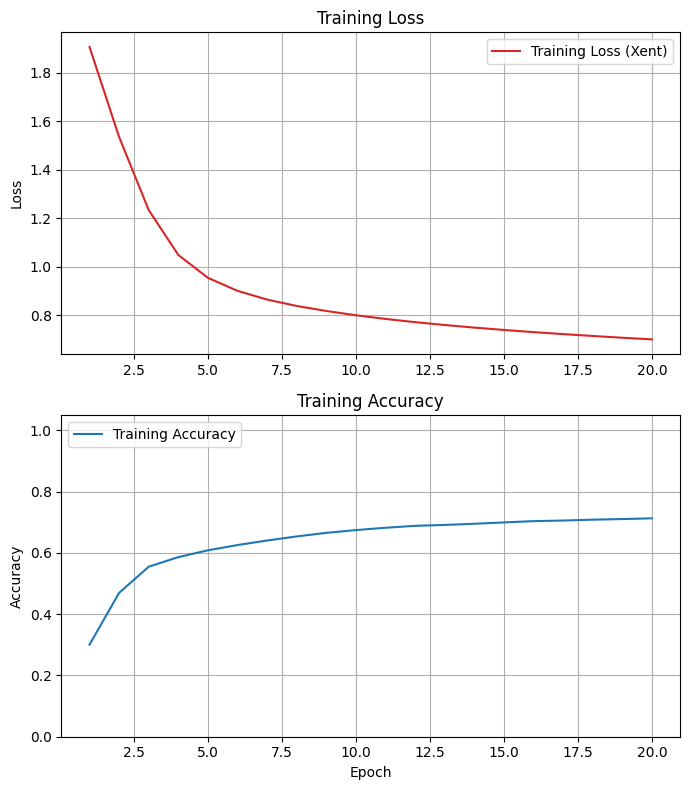

Final Training Loss:     0.6998
Final Training Accuracy: 0.7129


In [39]:
# Your code here

# Build the model
n_features = X_train.shape[1]
n_classes = 7

model = Sequential([
    Input(shape=(n_features,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Plot training and validation curves
plot_history(history)

In [40]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.7240             # Replace 0.0 with your answer

In [41]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7240


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


=== Batch size 4 ===


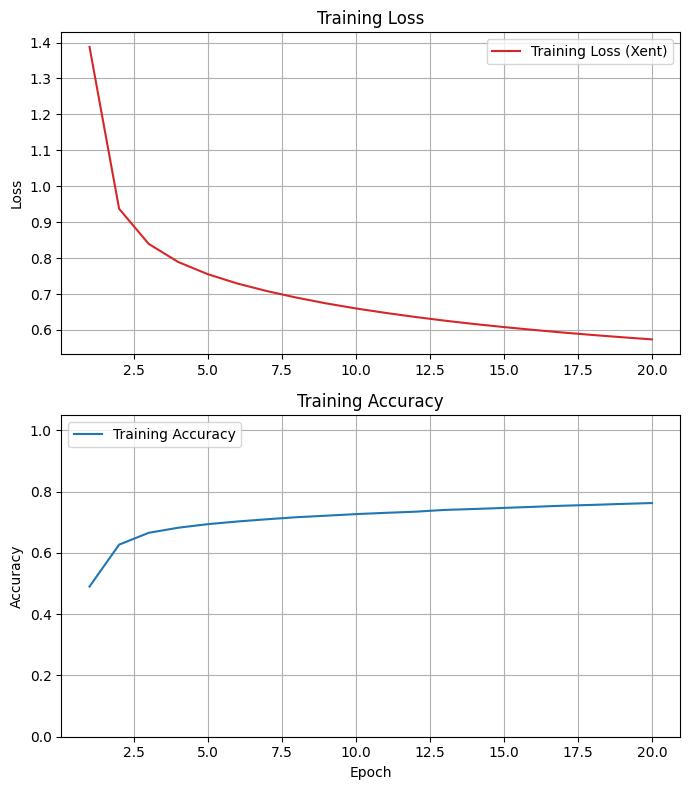

Final Training Loss:     0.5737
Final Training Accuracy: 0.7628
Final Train Acc: 0.7628 | Final Val Acc: 0.7517
Final Train Loss: 0.5737 | Final Val Loss: 0.5935

=== Batch size 8 ===


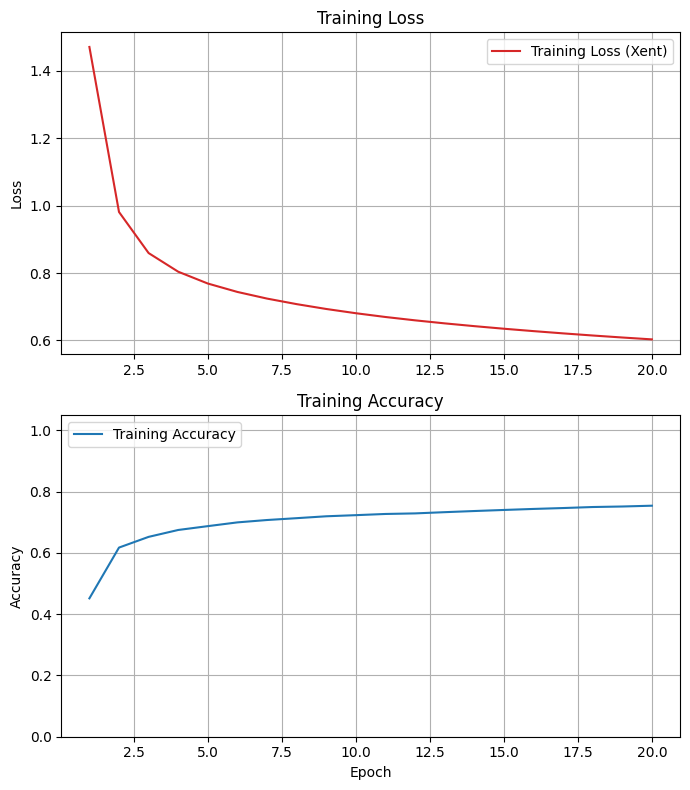

Final Training Loss:     0.6033
Final Training Accuracy: 0.7541
Final Train Acc: 0.7541 | Final Val Acc: 0.7452
Final Train Loss: 0.6033 | Final Val Loss: 0.6262

=== Batch size 16 ===


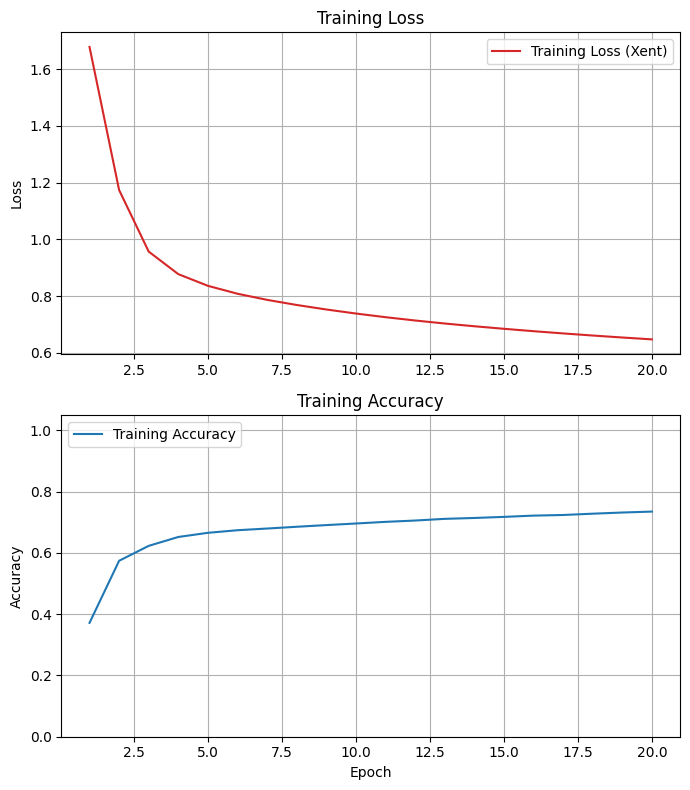

Final Training Loss:     0.6477
Final Training Accuracy: 0.7349
Final Train Acc: 0.7349 | Final Val Acc: 0.7342
Final Train Loss: 0.6477 | Final Val Loss: 0.6584

=== Batch size 128 ===


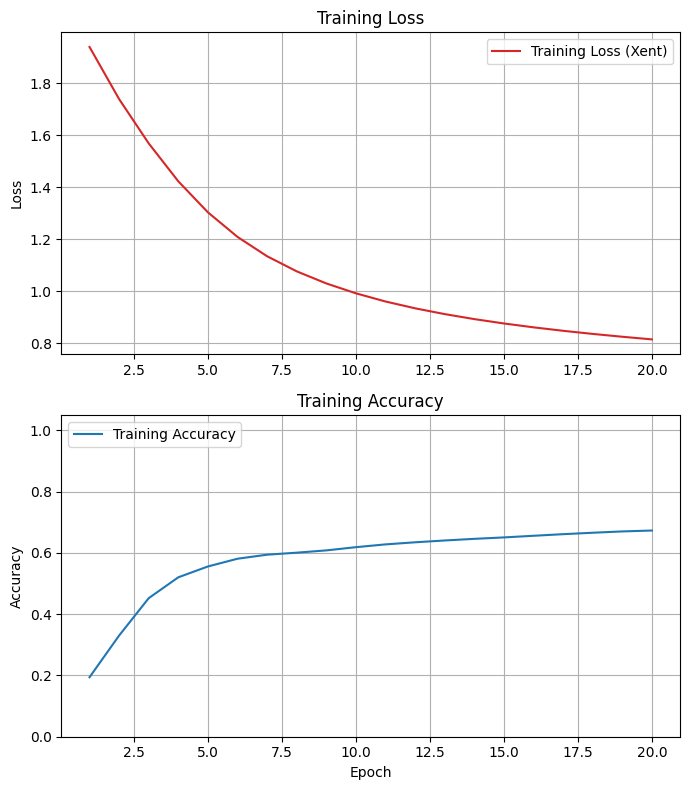

Final Training Loss:     0.8145
Final Training Accuracy: 0.6731
Final Train Acc: 0.6731 | Final Val Acc: 0.6588
Final Train Loss: 0.8145 | Final Val Loss: 0.8390

Best Val Accuracy by batch size: {4: '0.7517', 8: '0.7452', 16: '0.7342', 128: '0.6588'}


In [42]:
# Your code here

batch_sizes = [4, 8, 16, 128]
results_bs = {}

def build_baseline_model():
    n_features = X_train.shape[1]
    n_classes = 7
    m = Sequential([
        Input(shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    m.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

for bs in batch_sizes:
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    model_bs = build_baseline_model()
    history_bs = model_bs.fit(
        X_train, y_train,
        epochs=20,
        batch_size=bs,
        validation_split=0.2,
        verbose=0
    )

    print(f"\n=== Batch size {bs} ===")
    plot_history(history_bs)

    final_train_acc = history_bs.history['accuracy'][-1]
    final_val_acc = history_bs.history.get('val_accuracy', [np.nan])[-1]
    final_train_loss = history_bs.history['loss'][-1]
    final_val_loss = history_bs.history.get('val_loss', [np.nan])[-1]

    print(f"Final Train Acc: {final_train_acc:.4f} | Final Val Acc: {final_val_acc:.4f}")
    print(f"Final Train Loss: {final_train_loss:.4f} | Final Val Loss: {final_val_loss:.4f}")

    results_bs[bs] = {
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'best_val_acc': max(history_bs.history.get('val_accuracy', [np.nan])),
    }

summary = {bs: f"{vals['best_val_acc']:.4f}" for bs, vals in results_bs.items()}
print("\nBest Val Accuracy by batch size:", summary)

In [43]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4             # Replace 0 with your answer

In [44]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [45]:
# Set a2b to the best accuracy score found

a2b = 0.7553             # Replace 0.0 with your answer

In [46]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7553


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



=== Learning rate 0.001 ===


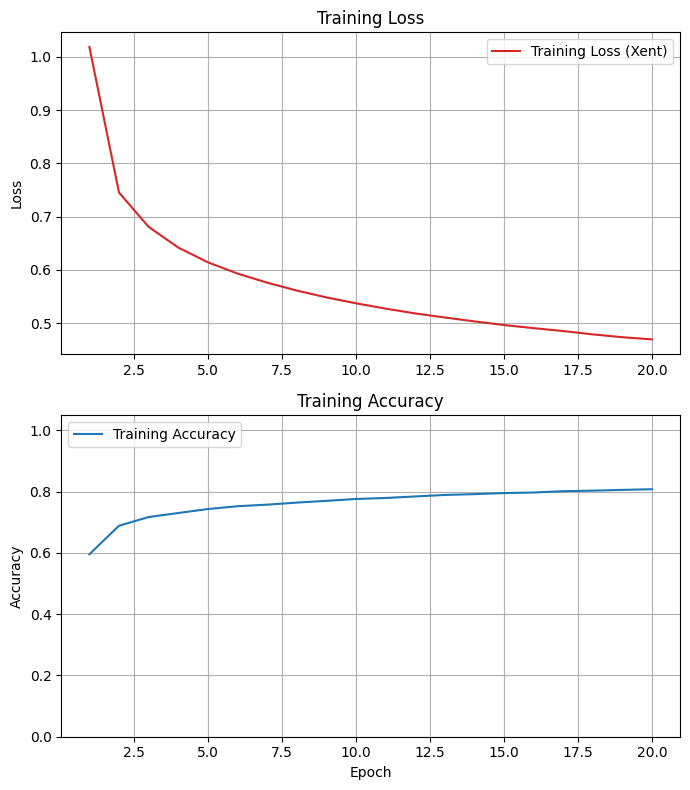

Final Training Loss:     0.4694
Final Training Accuracy: 0.8079
Final Train Acc: 0.8079 | Final Val Acc: 0.7862
Final Train Loss: 0.4694 | Final Val Loss: 0.5500

=== Learning rate 0.0005 ===


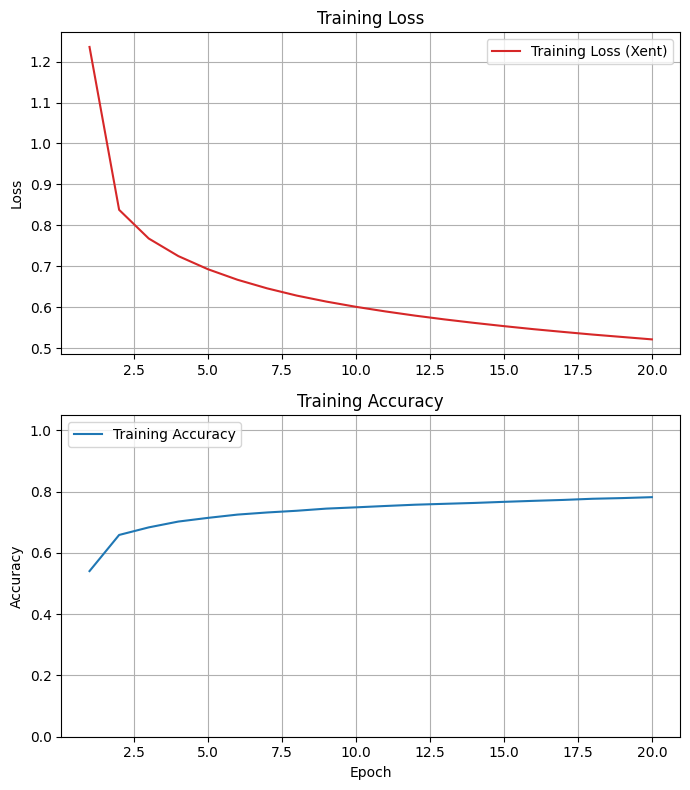

Final Training Loss:     0.5214
Final Training Accuracy: 0.7820
Final Train Acc: 0.7820 | Final Val Acc: 0.7696
Final Train Loss: 0.5214 | Final Val Loss: 0.5658

=== Learning rate 0.0001 ===


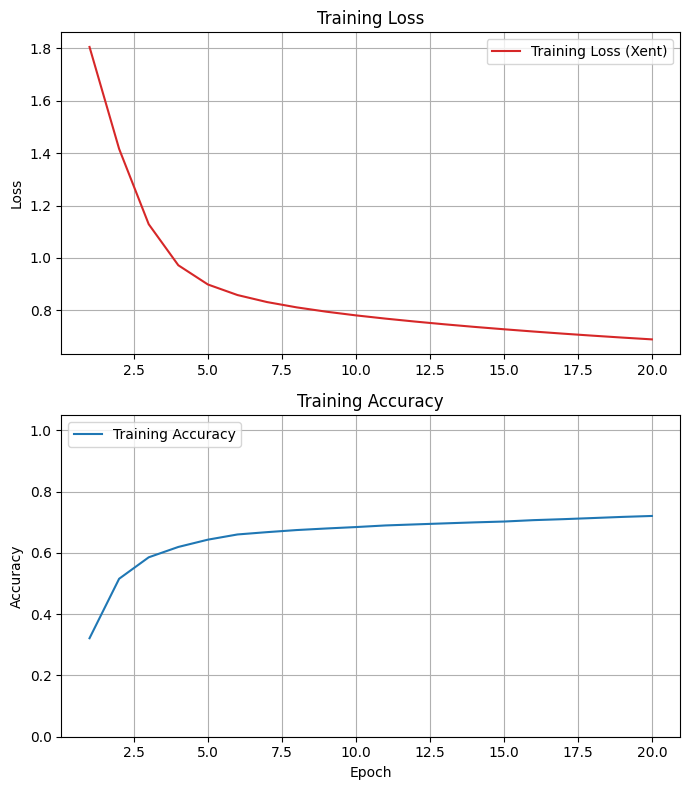

Final Training Loss:     0.6888
Final Training Accuracy: 0.7206
Final Train Acc: 0.7206 | Final Val Acc: 0.7186
Final Train Loss: 0.6888 | Final Val Loss: 0.7060

=== Learning rate 5e-05 ===


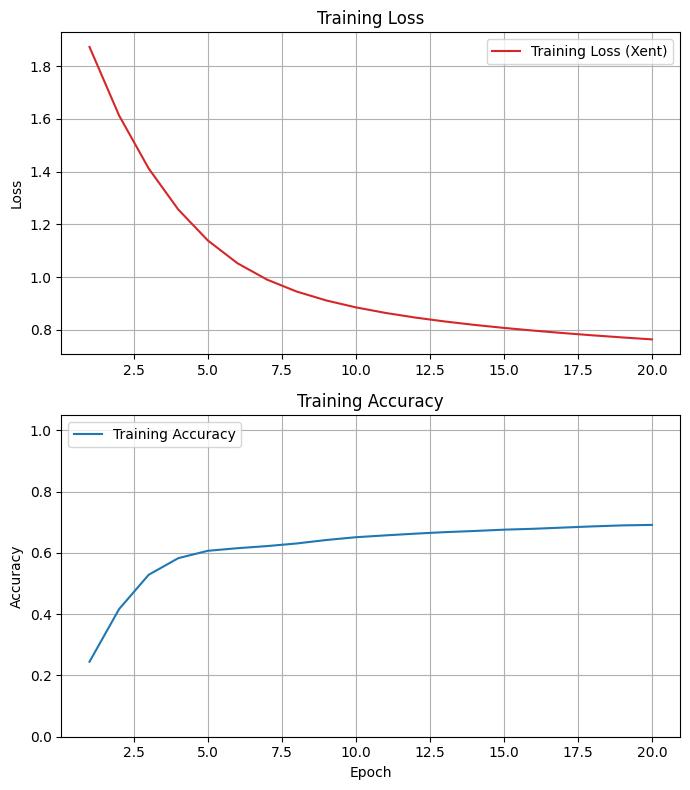

Final Training Loss:     0.7644
Final Training Accuracy: 0.6915
Final Train Acc: 0.6915 | Final Val Acc: 0.6822
Final Train Loss: 0.7644 | Final Val Loss: 0.7837

=== Learning rate 1e-05 ===


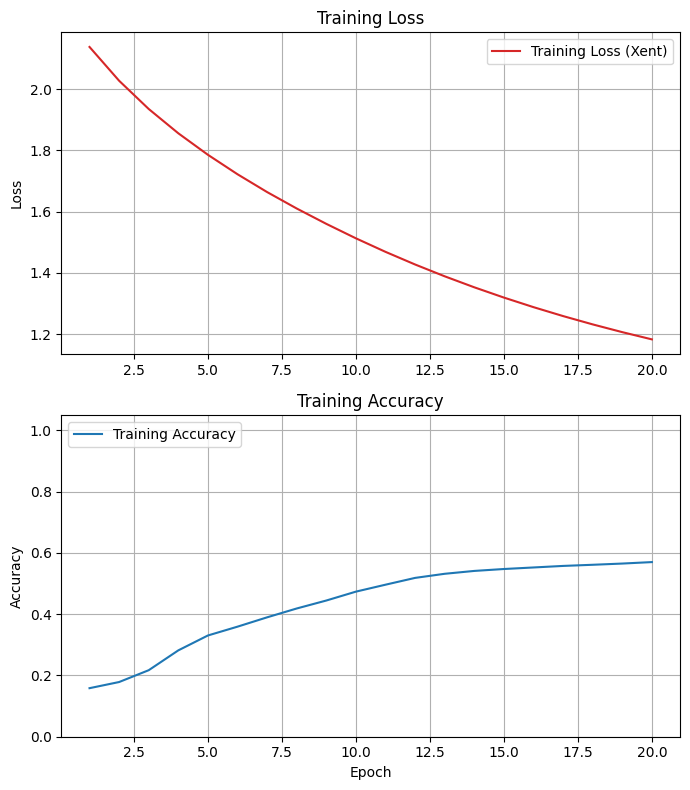

Final Training Loss:     1.1827
Final Training Accuracy: 0.5700
Final Train Acc: 0.5700 | Final Val Acc: 0.5613
Final Train Loss: 1.1827 | Final Val Loss: 1.1842

Best Val Accuracy by LR (epoch 20):
  0.001: 0.7862
  0.0005: 0.7696
  0.0001: 0.7186
  5e-05: 0.6822
  1e-05: 0.5613


In [47]:
# Your code here

lrs = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
results_lr = {}

def build_model(lr):
    n_features = X_train.shape[1]
    n_classes = 7
    m = Sequential([
        Input(shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    m.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

for lr in lrs:
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    model_lr = build_model(lr)
    history_lr = model_lr.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    print(f"\n=== Learning rate {lr} ===")
    plot_history(history_lr)

    final_train_acc = history_lr.history['accuracy'][-1]
    final_val_acc = history_lr.history.get('val_accuracy', [np.nan])[-1]
    final_train_loss = history_lr.history['loss'][-1]
    final_val_loss = history_lr.history.get('val_loss', [np.nan])[-1]

    print(f"Final Train Acc: {final_train_acc:.4f} | Final Val Acc: {final_val_acc:.4f}")
    print(f"Final Train Loss: {final_train_loss:.4f} | Final Val Loss: {final_val_loss:.4f}")

    results_lr[lr] = {
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'best_val_acc': max(history_lr.history.get('val_accuracy', [np.nan])),
    }

print("\nBest Val Accuracy by LR (epoch 20):")
for lr, vals in results_lr.items():
    print(f"  {lr:g}: {vals['final_val_acc']:.4f}")

In [48]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 0.001             # Replace 0.0 with your answer

In [49]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [50]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.7920             # Replace 0.0 with your answer

In [51]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7920


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


=== CosineDecay initial_lr 0.01 ===


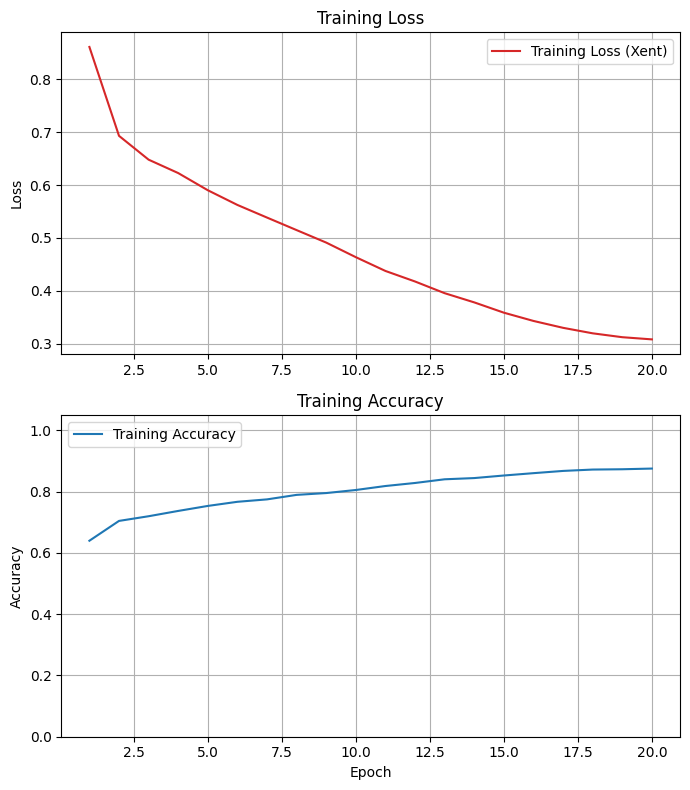

Final Training Loss:     0.3081
Final Training Accuracy: 0.8753
Final Train Acc: 0.8753 | Final Val Acc: 0.8346
Final Train Loss: 0.3081 | Final Val Loss: 0.4619

=== CosineDecay initial_lr 0.005 ===


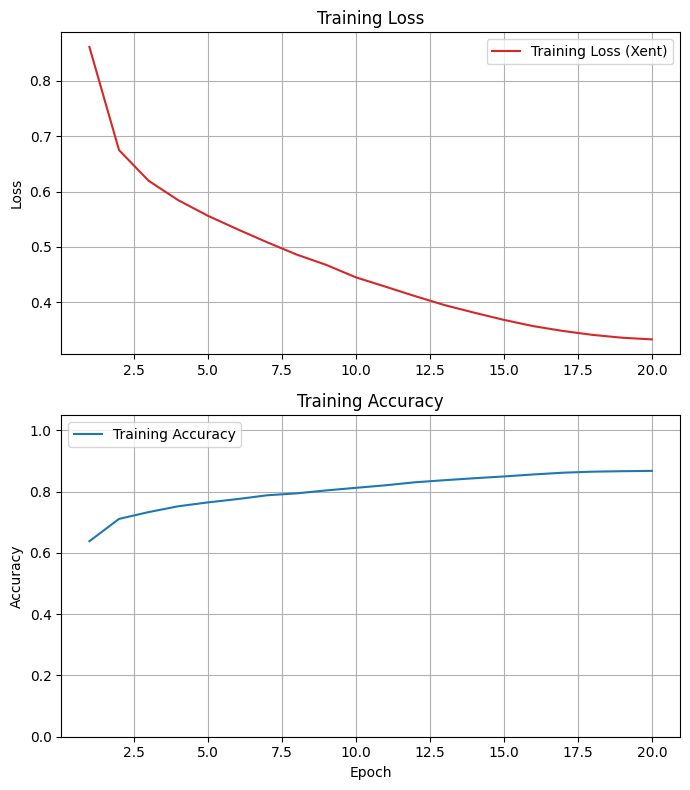

Final Training Loss:     0.3328
Final Training Accuracy: 0.8678
Final Train Acc: 0.8678 | Final Val Acc: 0.8232
Final Train Loss: 0.3328 | Final Val Loss: 0.5557

=== CosineDecay initial_lr 0.001 ===


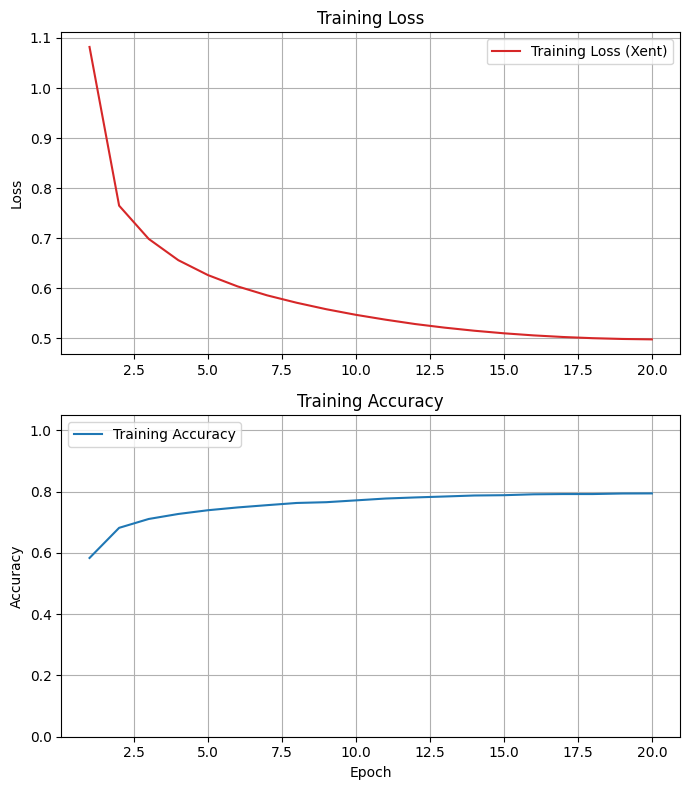

Final Training Loss:     0.4975
Final Training Accuracy: 0.7942
Final Train Acc: 0.7942 | Final Val Acc: 0.7738
Final Train Loss: 0.4975 | Final Val Loss: 0.5423

=== CosineDecay initial_lr 0.0005 ===


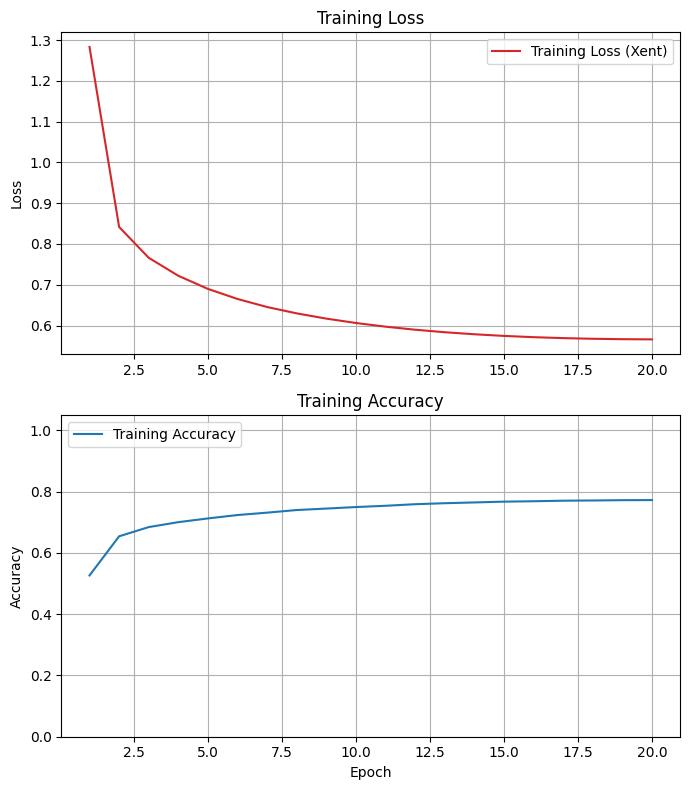

Final Training Loss:     0.5660
Final Training Accuracy: 0.7725
Final Train Acc: 0.7725 | Final Val Acc: 0.7524
Final Train Loss: 0.5660 | Final Val Loss: 0.6072

=== CosineDecay initial_lr 0.0001 ===


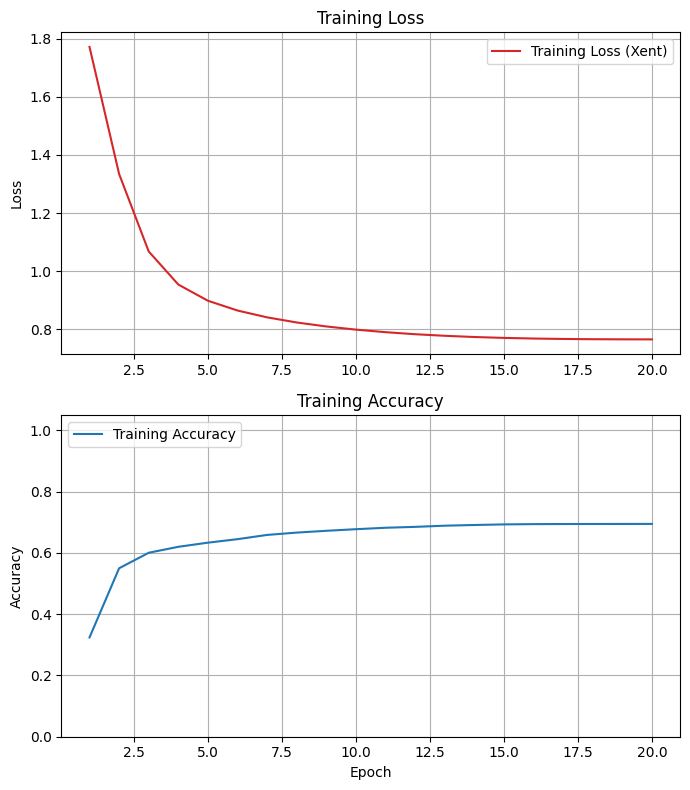

Final Training Loss:     0.7652
Final Training Accuracy: 0.6947
Final Train Acc: 0.6947 | Final Val Acc: 0.6822
Final Train Loss: 0.7652 | Final Val Loss: 0.7869

CosineDecay — Val Acc at epoch 20:
  0.01: 0.8346
  0.005: 0.8232
  0.001: 0.7738
  0.0005: 0.7524
  0.0001: 0.6822


In [52]:
# Your code here

init_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
results_cos = {}

epochs = 20
batch_size = 32
val_split = 0.2

n_train_effective = int(len(X_train) * (1 - val_split))
import math
steps_per_epoch = math.ceil(n_train_effective / batch_size)
decay_steps = epochs * steps_per_epoch

def build_model_with_cosine(init_lr):
    n_features = X_train.shape[1]
    n_classes = 7
    schedule = CosineDecay(initial_learning_rate=init_lr, decay_steps=decay_steps, alpha=0.0)
    m = Sequential([
        Input(shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    m.compile(
        optimizer=Adam(learning_rate=schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

for init_lr in init_lrs:
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    model_cos = build_model_with_cosine(init_lr)
    history_cos = model_cos.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=0
    )

    print(f"\n=== CosineDecay initial_lr {init_lr} ===")
    plot_history(history_cos)

    final_train_acc = history_cos.history['accuracy'][-1]
    final_val_acc = history_cos.history.get('val_accuracy', [np.nan])[-1]
    final_train_loss = history_cos.history['loss'][-1]
    final_val_loss = history_cos.history.get('val_loss', [np.nan])[-1]

    print(f"Final Train Acc: {final_train_acc:.4f} | Final Val Acc: {final_val_acc:.4f}")
    print(f"Final Train Loss: {final_train_loss:.4f} | Final Val Loss: {final_val_loss:.4f}")

    results_cos[init_lr] = {
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'best_val_acc': max(history_cos.history.get('val_accuracy', [np.nan])),
    }

print("\nCosineDecay — Val Acc at epoch 20:")
for init_lr, vals in results_cos.items():
    print(f"  {init_lr:g}: {vals['final_val_acc']:.4f}")

In [53]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 0.005             # Replace 0.0 with your answer

In [54]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0050


In [55]:
# Set a4b to the best accuracy found

a4b = 0.8232             # Replace 0.0 with your answer

In [56]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8232


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

=== Best configuration ===
Scheduler: CosineDecay
Initial LR: 0.005
Batch size: 32


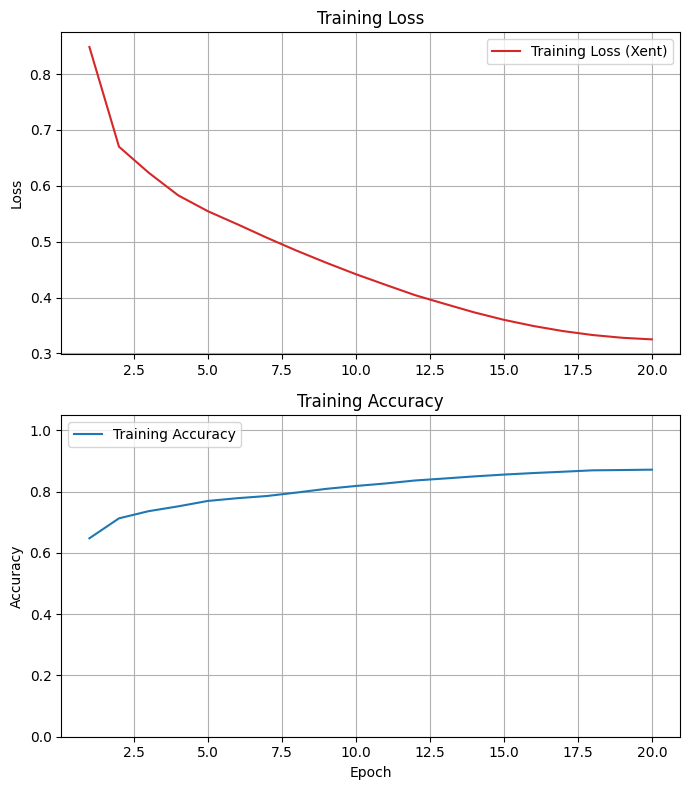

Final Training Loss:     0.3253
Final Training Accuracy: 0.8718
Test Loss: 0.4507 | Test Accuracy: 0.8339


In [57]:
# Your code here -- add as many cells as you need

best_batch_size = 32
use_cosine = True
best_init_lr = 5e-3
epochs = 20
val_split = 0.2

import math
n_train_effective = int(len(X_train) * (1 - val_split))
steps_per_epoch = math.ceil(n_train_effective / best_batch_size)
decay_steps = epochs * steps_per_epoch

def build_best_model():
    n_features = X_train.shape[1]
    n_classes = 7
    if use_cosine:
        schedule = CosineDecay(initial_learning_rate=best_init_lr,
                               decay_steps=decay_steps,
                               alpha=0.0)
        opt = Adam(learning_rate=schedule)
    else:
        opt = Adam(learning_rate=1e-3)

    model = Sequential([
        Input(shape=(n_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

best_model = build_best_model()
history_best = best_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=best_batch_size,
    validation_split=val_split,
    verbose=0
)

print("=== Best configuration ===")
print(f"Scheduler: {'CosineDecay' if use_cosine else 'Constant'}")
print(f"Initial LR: {best_init_lr if use_cosine else '1e-3'}")
print(f"Batch size: {best_batch_size}")
plot_history(history_best)

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

In [58]:
# Set a5a to the best training accuracy found by your best model

a5a = 0.8749             # Replace 0.0 with your answer

In [59]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8749


In [60]:
# Set a5b to the test accuracy found by your best model

a5b = 0.8336             # Replace 0.0 with your answer

In [61]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8336


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


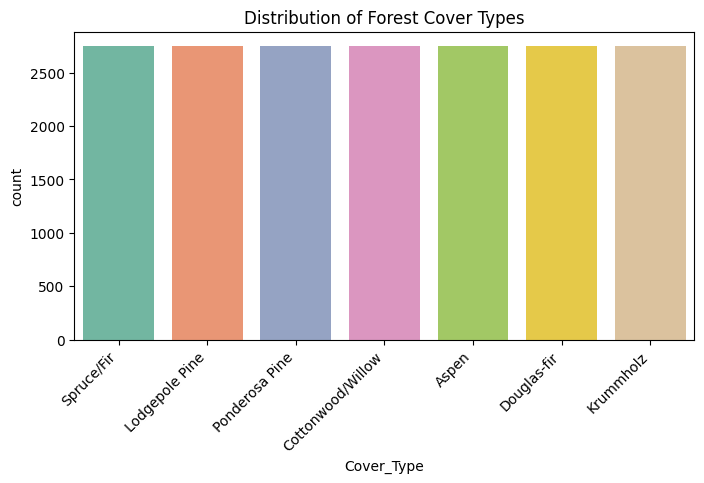

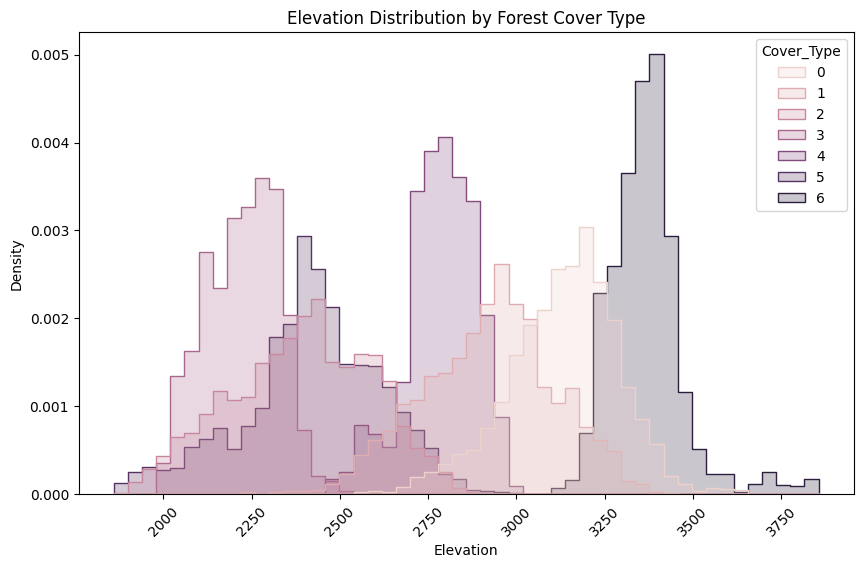

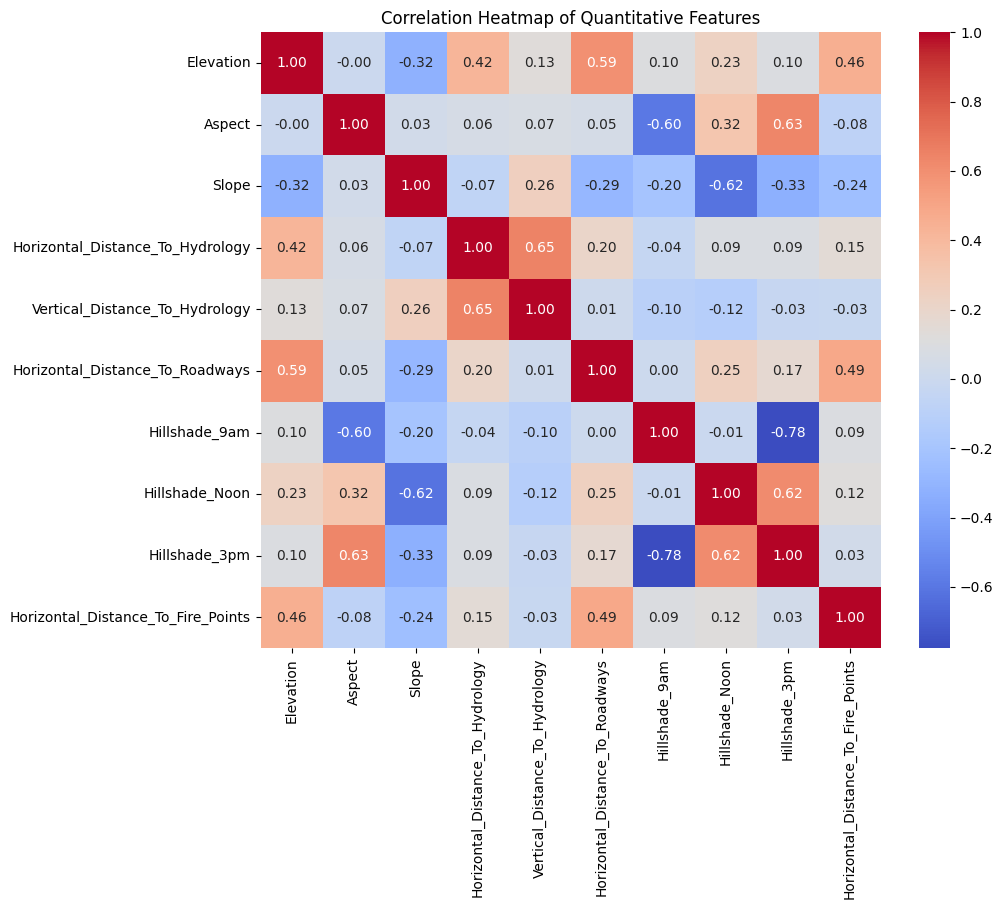

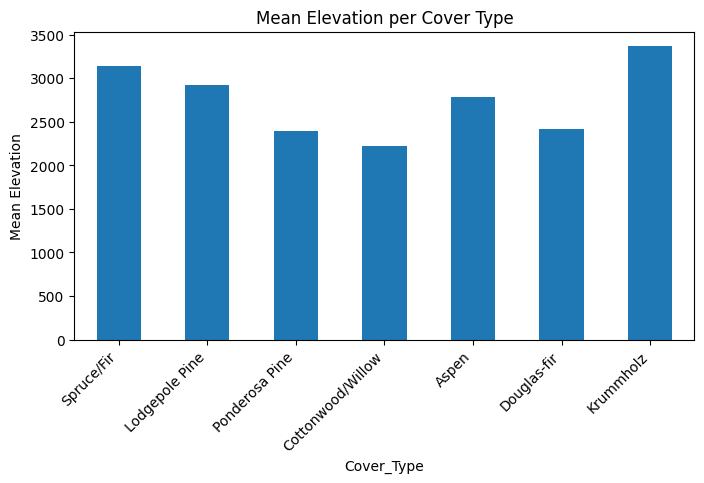

In [62]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
